# FakeNewsDetection

In this notebook, we will be solving a use case of 'Fake News Detection' - Predict if a news published in an article is 'Real' or 'Fake' for a sample data using ML Algorithms!

**Note**: Update variables under **Variables** section if required before running the notebook. To run notebook cell by cell, click on a cell and click **Run** button below the Menu bar. Or to run all cells, select **Cell --> Run** All from Menu bar.

### Library imports

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk #Import NLTK ---> Natural Language Toolkit
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     /home/divinecodes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/divinecodes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Description

The sample dataset we use is **fakedata.csv** which is available in the current directory. This can be replaced with any dataset containing a text column with 'News' and a label column citing is the news is 'Real' or 'Fake'

Attributes of **fakedata.csv** dataset:
   1. **text**: text of the article
   2. **label**: a label that marks the article as potentially unreliable
        
        1: fake 
        0: real

### Variables

In [2]:
#Specify the input filename
INPUTFILE = r'fake_news_train.csv'

In [3]:
#Specify the ratio of test data for prediction
test_data_ratio = 0.1

### Data Loading & Visualization

In [4]:
# Load the file for analysis. Change the path of the file if required
df = pd.read_csv(INPUTFILE, encoding='utf-8',header=0)

In [5]:
df.head()

,news_text,label
0,Get the latest from TODAY Sign up for our news...,fake
1,2d Conan On The Funeral Trump Will Be Invited...,fake
2,It’s safe to say that Instagram Stories has fa...,real
3,Much like a certain Amazon goddess with a lass...,real
4,At a time when the perfect outfit is just one ...,real


In [6]:
df['label'] = np.where(df['label'] == 'fake', 1, 0)

In [7]:
df.shape

(4998, 2)

The data has 2 columns. 'news_text' column which contains the text which has the News data and 'label' column which contains the label if the news is Real or Fake **{fake, real}**

([<matplotlib.patches.Wedge at 0x7ff6d8152220>,
 [Text(-1.1464648034448126, 0.3544269381159497, 'fake'),
  Text(1.1464648034448124, -0.35442693811595033, 'real')],
 [Text(-0.6687711353428074, 0.20674904723430398, '40.5%'),
  Text(0.6687711353428072, -0.20674904723430432, '59.5%')])

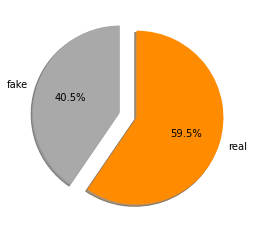

In [8]:
#Plot the distribution of the label column in the data
cat_target=df.label
label_size = [cat_target.sum(),len(cat_target)-cat_target.sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['darkgrey','darkorange'],startangle=90,shadow=True,labels=['fake','real'],autopct='%1.1f%%')

### Data Preprocessing

Since the input data is 'text', it is necessary to preprocess it. The steps in preprocessing include **Tokenization, Stop word removal, Stemming, Tf-Idf Vectorizer.** During this preprocessing phase, the data is cleansed,treated and converted to vectors for the machine/algorithm to understand!

In [9]:
# create a function to preprocess the data
def preprocess_data(data):
  
  # 1. Tokenization
    tk = RegexpTokenizer('\s+', gaps = True)
    text_data = [] # List for storing the tokenized data
    for values in data.news_text:
        tokenized_data = tk.tokenize(values) # Tokenize the news
        text_data.append(tokenized_data) # append the tokenized data

  # 2. Stopword Removal

  # Extract the stopwords
    sw = stopwords.words('english')
    clean_data = [] # List for storing the clean text
  # Remove the stopwords using stopwords
    for data in text_data:
        clean_text = [words.lower() for words in data if words.lower() not in sw]
        clean_data.append(clean_text) # Appned the clean_text in the clean_data list
  
  # 3. Stemming

  # Create a stemmer object
    ps = PorterStemmer()
    stemmed_data = [] # List for storing the stemmed data
    for data in clean_data:
        stemmed_text = [ps.stem(words) for words in data] # Stem the words
        stemmed_data.append(stemmed_text) # Append the stemmed text
  

  # 4. tfidf vectorizer --> Term Frequency Inverse Document Frequency  
  # Flatten the stemmed data

    updated_data = []
    for data in stemmed_data:
        updated_data.append(" ".join(data))

  # TFID Vector object
    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(updated_data)

    return tfidf_matrix

In [10]:
# preprocess the text data
preprocessed_data = preprocess_data(df.drop('label', axis=1))

The output of this preprocessing step is a matrix of vectors representing the input data. We concatenate this with the target column for subsequent steps

In [11]:
features_df = pd.DataFrame(preprocessed_data.toarray())
datadf = pd.concat([features_df,df['label']],axis=1)

### Model Development

We will be using **Scikit-learn** ML library for training and predicting. There are many algorithms available in Scikit-learn. We will be experimenting with **Logistic Regression & NaiveBayes** algorithms. Other algorithms available in the sklearn library https://scikit-learn.org/stable/supervised_learning.html that solves **Classification** problems can also be used

In [12]:
# Split data into train & test in the ratio of 80:20
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(datadf, datadf.label, test_size=test_data_ratio, random_state = 42)

##### Code for Evaluation Metrics

Since this is a Classification problem, we write a function to get evaluation metrics like Confusion Matrix, Accuracy, Precision, Recall etc.

In [13]:
# Evaluation Metrics for Classification models
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function for deriving a classification report & Confusion matrix for any algorithm
def compute_metrics(data, y_true, model_obj, model):

        # Make predictions
    y_pred = model_obj.predict(data)
    print(metrics.classification_report(y_true, y_pred,target_names = ['real', 'fake']))
    
    cm = confusion_matrix(y_true, y_pred, labels=model_obj.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['real', 'fake'])
    disp.plot()
    plt.show()

###### Logistic Regression Model

In [14]:
# Import LogisticRegression model from sklearn library
from sklearn.linear_model import LogisticRegressionCV

# Initialize the model 
lr_reg = LogisticRegressionCV(Cs=20, cv=3, random_state=42)

# fit the model
lr_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, cv=3, random_state=42)

              precision    recall  f1-score   support

        real       1.00      1.00      1.00      2680
        fake       1.00      1.00      1.00      1818

    accuracy                           1.00      4498
   macro avg       1.00      1.00      1.00      4498
weighted avg       1.00      1.00      1.00      4498



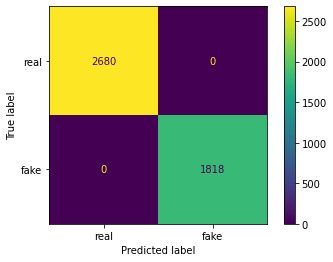

In [15]:
#  Compute the Evaluation Metrics for train set of Logistic Regression model
lr_metrics_train =  compute_metrics(X_train, y_train, lr_reg, 'LogisticRegression')
lr_metrics_train

              precision    recall  f1-score   support

        real       1.00      1.00      1.00       296
        fake       1.00      1.00      1.00       204

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



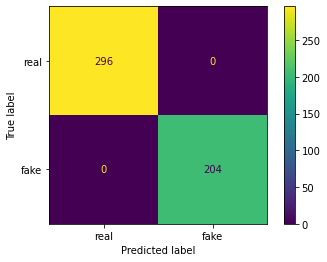

In [16]:
# Compute the Evaluation Metrics for test set for Logistic Regression model
lr_metrics =  compute_metrics(X_test, y_test, lr_reg, 'LogisticRegression')
lr_metrics

###### Naive Bayes Model

In [17]:
# Import Naive Bayes model from sklearn library
from sklearn.naive_bayes import MultinomialNB

# Initialize the model 
mnb = MultinomialNB(alpha=0.0)

# Fit the model
mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.0)

              precision    recall  f1-score   support

        real       1.00      0.99      0.99      2680
        fake       0.98      1.00      0.99      1818

    accuracy                           0.99      4498
   macro avg       0.99      0.99      0.99      4498
weighted avg       0.99      0.99      0.99      4498



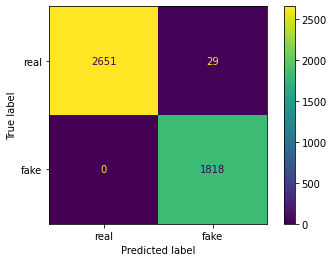

In [18]:
#  Compute the Evaluation Metrics for train set of Naive Bayes model
mnb_metrics_train = compute_metrics(X_train, y_train, mnb, 'Naive Bayes')
mnb_metrics_train

              precision    recall  f1-score   support

        real       1.00      0.84      0.91       296
        fake       0.81      1.00      0.90       204

    accuracy                           0.91       500
   macro avg       0.91      0.92      0.91       500
weighted avg       0.92      0.91      0.91       500



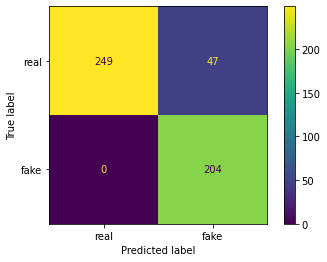

In [19]:
#  Compute the Evaluation Metrics for test set of Naive Bayes model
mnb_metrics = compute_metrics(X_test, y_test, mnb, 'Naive Bayes')
mnb_metrics